In [ ]:
!pip install jaxtyping equinox

In [ ]:
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

import equinox as eqx

In [ ]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

key = jax.random.PRNGKey(SEED)

In [ ]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [ ]:
import pandas as pd
data  = [(x.numpy()[0], y) for x, y in iter(train_dataset)]
df    = pd.DataFrame(data, columns=['features', 'labels'])
df

,features,labels
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",5
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",0
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",4
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",1
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",9
...,...,...
59995,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",8
59996,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",3
59997,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",5
59998,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",6


In [ ]:
df['features'][0]

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    

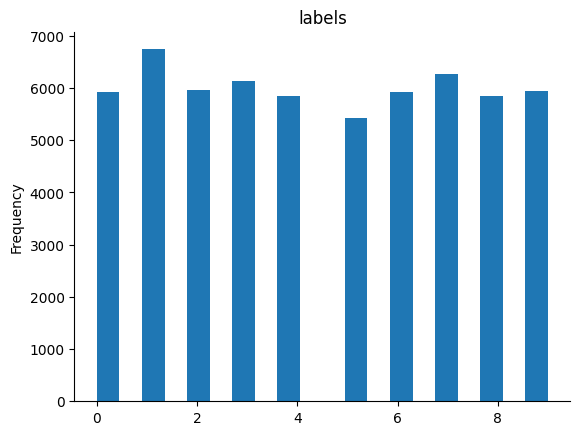

In [ ]:
from matplotlib import pyplot as plt
df['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Checking our data a bit (by now, everyone knows what the MNIST dataset looks like)
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_y.shape)  # 64
print(dummy_y)

(64, 1, 28, 28)
(64,)
[0 2 2 4 5 4 1 0 5 5 2 3 8 1 3 0 5 5 1 2 1 7 6 5 6 1 4 3 1 9 8 3 9 8 3 6 6
 8 2 3 3 3 5 4 5 4 1 5 5 4 8 4 7 8 2 6 7 8 0 9 0 3 1 4]


In [ ]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 32 32"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x


key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

In [ ]:
print(model)

CNN(
  layers=[
    Conv2d(
      num_spatial_dims=2,
      weight=f32[3,1,4,4],
      bias=f32[3,1,1],
      in_channels=1,
      out_channels=3,
      kernel_size=(4, 4),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True
    ),
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    <wrapped function relu>,
    <wrapped function ravel>,
    Linear(
      weight=f32[512,1728],
      bias=f32[512],
      in_features=1728,
      out_features=512,
      use_bias=True
    ),
    <wrapped function sigmoid>,
    Linear(
      weight=f32[64,512],
      bias=f32[64],
      in_features=512,
      out_features=64,
      use_bias=True
    ),
    <wrapped function relu>,
    Linear(
      weight=f32[10,64],
      bias=f32[10],
      in_features=64,
      out_features=10,
      use_bias=True
  

In [ ]:
def loss(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value.shape)  # scalar loss
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions

()
(64, 10)


In [ ]:
# This will work!
params, static = eqx.partition(model, eqx.is_array)


def loss2(params, static, x, y):
    model = eqx.combine(params, static)
    return loss(model, x, y)


loss_value, grads = jax.value_and_grad(loss2)(params, static, dummy_x, dummy_y)
print(loss_value)

2.285676


In [ ]:
# This is an error!
jax.value_and_grad(loss)(model, dummy_x, dummy_y)

TypeError: ignored

In [ ]:
# This will work too!
value, grads = eqx.filter_value_and_grad(loss)(model, dummy_x, dummy_y)
print(value)

2.285676


In [ ]:
loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

In [ ]:
def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)

In [ ]:
evaluate(model, testloader)

(Array(2.3078082, dtype=float32), Array(0.10081609, dtype=float32))

In [ ]:
optim = optax.adamw(LEARNING_RATE)

In [ ]:
def train(
    model: CNN,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model

In [ ]:
model = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY)

step=0, train_loss=2.3139700889587402, test_loss=2.3045575618743896, test_accuracy=0.12659235298633575
step=30, train_loss=2.1834115982055664, test_loss=2.168821334838867, test_accuracy=0.32354697585105896
step=60, train_loss=1.9426651000976562, test_loss=1.884477972984314, test_accuracy=0.6247014403343201
step=90, train_loss=1.5136895179748535, test_loss=1.4511332511901855, test_accuracy=0.737261176109314
step=120, train_loss=1.0158263444900513, test_loss=1.0274163484573364, test_accuracy=0.8037420511245728
step=150, train_loss=0.7833031415939331, test_loss=0.7509862780570984, test_accuracy=0.8215565085411072
step=180, train_loss=0.6055166721343994, test_loss=0.5831165909767151, test_accuracy=0.8663415312767029
step=210, train_loss=0.5323667526245117, test_loss=0.5041787028312683, test_accuracy=0.8733081221580505
step=240, train_loss=0.4918504059314728, test_loss=0.44156938791275024, test_accuracy=0.8894307613372803
step=270, train_loss=0.529234766960144, test_loss=0.4182316064834595,